# Credit Payment Default

## Import Packages

In [130]:
import warnings
warnings.filterwarnings('ignore')

from time import perf_counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, log_loss, confusion_matrix, classification_report, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, r2_score, make_scorer
from sklearn import tree
from sklearn.inspection import plot_partial_dependence

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from lime.lime_tabular import LimeTabularExplainer

import codecs

from sklearn.model_selection import KFold, cross_validate

from h2o.automl import H2OAutoML

from h2o import H2OFrame

import h2o

from scipy import stats

import mlflow


## Data Import

In [2]:
df = pd.read_csv('../data/credit_payment_default/UCI_Credit_Card.csv')
df.drop('ID', axis=1, inplace=True)

In [3]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df.shape

(30000, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6                     30000 non-null float64
PAY_AMT1  

In [6]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
def get_missing_report(df):
    missing_df = (df.isnull().sum()/len(df)).rename_axis('columns').to_frame('missing_perc').reset_index()
    missing_df['missing_perc'] = missing_df['missing_perc'] * 100
    missing_df['type'] = missing_df['columns'].apply(lambda col: str(df[col].dtypes))
    return missing_df.sort_values(by = 'missing_perc', ascending=False)

In [8]:
get_missing_report(df)

,columns,missing_perc,type
0,LIMIT_BAL,0.0,float64
1,SEX,0.0,int64
22,PAY_AMT6,0.0,float64
21,PAY_AMT5,0.0,float64
20,PAY_AMT4,0.0,float64
19,PAY_AMT3,0.0,float64
18,PAY_AMT2,0.0,float64
17,PAY_AMT1,0.0,float64
16,BILL_AMT6,0.0,float64
15,BILL_AMT5,0.0,float64


No missing data

In [9]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [10]:
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [11]:
df[categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
dtypes: int64(9)
memory usage: 2.1 MB


In [12]:
df['SEX'].value_counts(normalize=True)

2    0.603733
1    0.396267
Name: SEX, dtype: float64

In [13]:
df['EDUCATION'].value_counts(normalize=True)

2    0.467667
1    0.352833
3    0.163900
5    0.009333
4    0.004100
6    0.001700
0    0.000467
Name: EDUCATION, dtype: float64

In [14]:
df['MARRIAGE'].value_counts(normalize=True)

2    0.532133
1    0.455300
3    0.010767
0    0.001800
Name: MARRIAGE, dtype: float64

In [15]:
target_col = 'default.payment.next.month'

In [16]:
numerical_cols = [col for col in df.columns if col not in categorical_cols and not col == target_col]
numerical_cols

['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [17]:
df[numerical_cols].describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


## EDA

In [18]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [19]:
df['default.payment.next.month'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

Data is imbalanced

<AxesSubplot:xlabel='SEX', ylabel='count'>

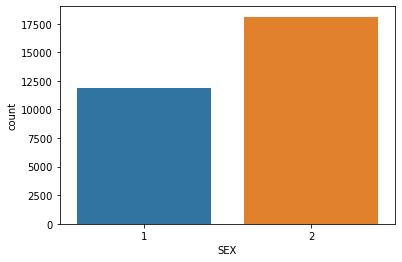

In [20]:
sns.countplot(df['SEX'])

In [21]:
df['EDUCATION'].value_counts(normalize=True)

2    0.467667
1    0.352833
3    0.163900
5    0.009333
4    0.004100
6    0.001700
0    0.000467
Name: EDUCATION, dtype: float64

<AxesSubplot:xlabel='EDUCATION', ylabel='count'>

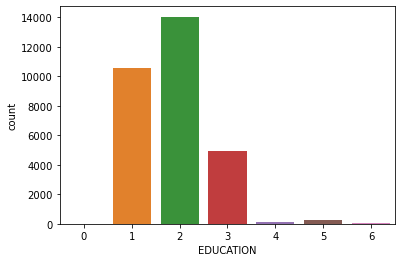

In [22]:
sns.countplot(df['EDUCATION'])

<AxesSubplot:xlabel='MARRIAGE', ylabel='count'>

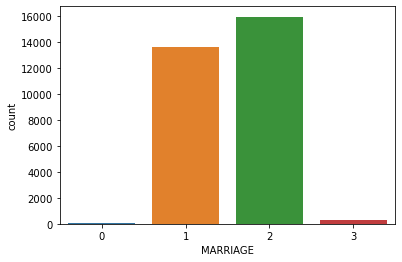

In [23]:
sns.countplot(df['MARRIAGE'])

<AxesSubplot:xlabel='MARRIAGE', ylabel='count'>

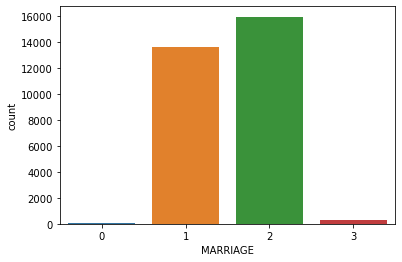

In [24]:
sns.countplot(df['MARRIAGE'])

In [25]:
default_df = df[df['default.payment.next.month'] == 1]

<AxesSubplot:xlabel='PAY_0', ylabel='count'>

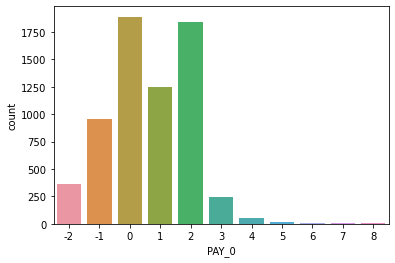

In [26]:
sns.countplot(default_df['PAY_0'])

<AxesSubplot:xlabel='PAY_2', ylabel='count'>

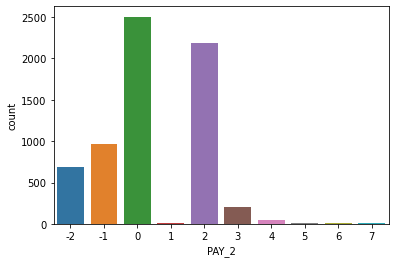

In [27]:
sns.countplot(default_df['PAY_2'])

<AxesSubplot:xlabel='PAY_3', ylabel='count'>

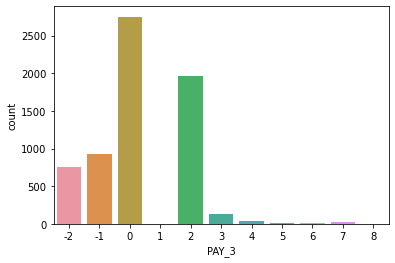

In [28]:
sns.countplot(default_df['PAY_3'])

<AxesSubplot:xlabel='PAY_4', ylabel='count'>

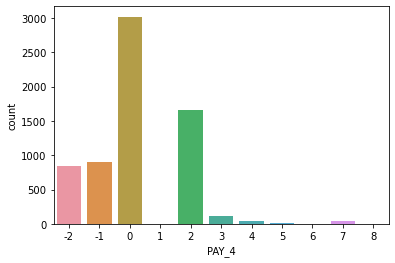

In [29]:
sns.countplot(default_df['PAY_4'])

<AxesSubplot:xlabel='PAY_5', ylabel='count'>

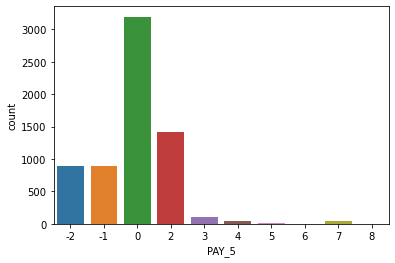

In [30]:
sns.countplot(default_df['PAY_5'])

<AxesSubplot:xlabel='PAY_6', ylabel='count'>

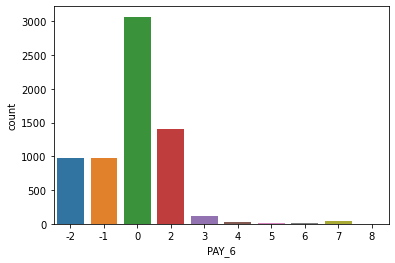

In [31]:
sns.countplot(default_df['PAY_6'])

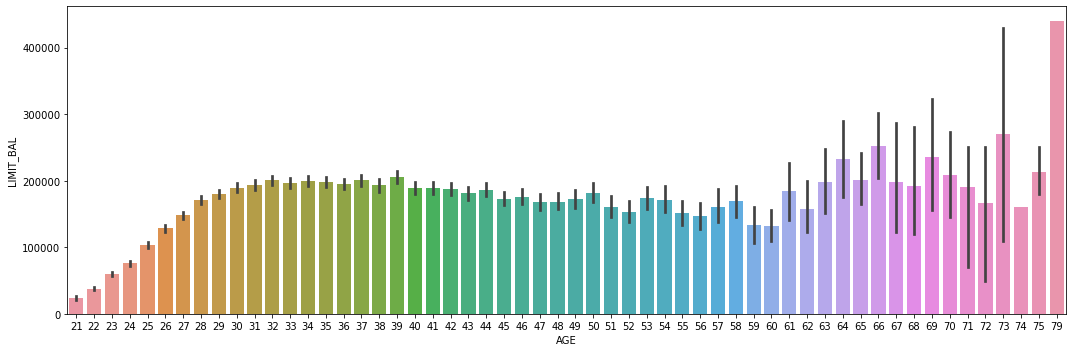

In [32]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='AGE', y='LIMIT_BAL', data=df)
plt.tight_layout()
plt.show()

In [33]:
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=[20, 30, 40, 60, 80])
age_dict = dict(zip(df['AGE_GROUP'].unique(), [i for i in range(1, (df['AGE_GROUP'].nunique() + 1))]))
age_dict

{Interval(20, 30, closed='right'): 1,
 Interval(30, 40, closed='right'): 2,
 Interval(40, 60, closed='right'): 3,
 Interval(60, 80, closed='right'): 4}

In [34]:
df['AGE_GROUP'] = df['AGE_GROUP'].apply(lambda age: age_dict[age])

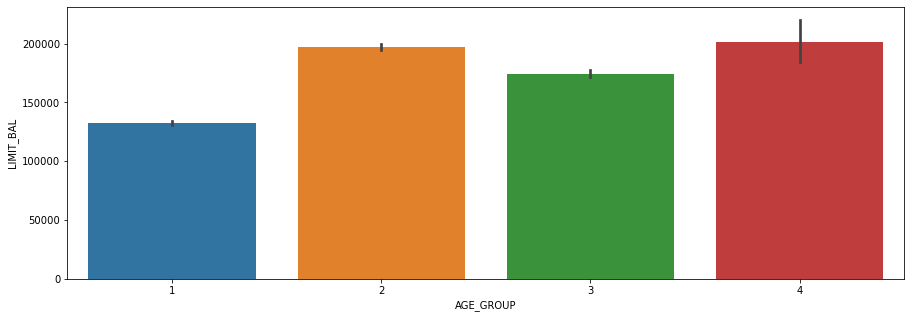

In [35]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='AGE_GROUP', y='LIMIT_BAL', data=df)
plt.show()

In [36]:
def get_payment_due_category(pay_category):
    if pay_category <= 0:
        return 'No Delay'
    if pay_category in range(1, 4):
        return 'Normal Delay'
    else:
        return 'High Delay'

In [37]:
pay_cat_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for col in pay_cat_cols:
    df[col] = df[col].apply(lambda pay_cat: get_payment_due_category(pay_cat))

In [38]:
default_df = df[df['default.payment.next.month'] == 1]

In [39]:
default_df['AGE_GROUP'].value_counts(normalize=True)

1    0.372363
2    0.329867
3    0.286769
4    0.011001
Name: AGE_GROUP, dtype: float64

In [40]:
df.pivot_table(index='AGE_GROUP', columns='PAY_0', values='PAY_AMT1', fill_value=0.0)

PAY_0,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,478.283019,5653.499822,2593.755198
2,456.195122,6928.947769,3587.492722
3,362.543478,6853.104197,3021.445938
4,0.000000,7596.784615,1944.789474


In [41]:
default_df.pivot_table(index='AGE_GROUP', columns='PAY_0', values='PAY_AMT1', fill_value=0.0)

PAY_0,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,660.441176,3630.446864,2114.543057
2,680.769231,5036.528623,2600.688995
3,312.965517,4188.536773,3244.516096
4,0.000000,8785.266667,1111.906977


In [42]:
df.pivot_table(index='AGE_GROUP', columns='PAY_2', values='PAY_AMT2', fill_value=0.0)

PAY_2,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,551.448276,5394.002812,2635.411111
2,203.361702,7066.321110,3916.275786
3,424.280000,6980.043286,2944.331034
4,0.000000,5438.619469,1858.295455


In [43]:
default_df.pivot_table(index='AGE_GROUP', columns='PAY_2', values='PAY_AMT2', fill_value=0.0)

PAY_2,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,316.741935,3215.587217,2088.809168
2,196.807692,4404.961404,2932.415989
3,129.071429,4472.381757,2479.136035
4,0.000000,3954.530612,1568.086957


In [44]:
df.pivot_table(index='AGE_GROUP', columns='PAY_3', values='PAY_AMT3', fill_value=0.0)

PAY_3,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,670.061538,4665.315382,2514.452280
2,561.142857,6260.952746,3361.215686
3,833.243902,6008.141481,2645.125000
4,0.000000,7622.665272,3388.322581


In [45]:
default_df.pivot_table(index='AGE_GROUP', columns='PAY_3', values='PAY_AMT3', fill_value=0.0)

PAY_3,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,720.136364,3323.388265,2414.755152
2,161.814815,4695.426316,2758.523364
3,650.347826,3464.505188,2492.905901
4,0.000000,2594.338983,952.000000


In [46]:
df.pivot_table(index='AGE_GROUP', columns='PAY_4', values='PAY_AMT4', fill_value=0.0)

PAY_4,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,250.333333,4381.386865,2249.124812
2,514.021739,5803.898543,2876.059603
3,533.574468,5279.910656,2706.286177
4,0.000000,4550.950617,3116.178571


In [47]:
default_df.pivot_table(index='AGE_GROUP', columns='PAY_4', values='PAY_AMT4', fill_value=0.0)

PAY_4,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,235.849057,3325.165138,2094.222552
2,108.448276,3921.878261,2568.061818
3,411.454545,3289.857569,2673.973535
4,0.000000,2129.145161,1456.909091


In [48]:
df.pivot_table(index='AGE_GROUP', columns='PAY_5', values='PAY_AMT5', fill_value=0.0)

PAY_5,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,265.789474,4449.476487,2283.861472
2,729.729730,5492.708189,3179.540816
3,339.125000,5246.032316,2177.706989
4,12666.666667,6627.012195,1879.173913


In [49]:
default_df.pivot_table(index='AGE_GROUP', columns='PAY_5', values='PAY_AMT5', fill_value=0.0)

PAY_5,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,207.843137,3213.099174,2016.066116
2,214.285714,3748.125223,3303.355042
3,434.647059,3747.980392,2018.673469
4,0.000000,2199.406780,1373.785714


In [50]:
df.pivot_table(index='AGE_GROUP', columns='PAY_6', values='PAY_AMT6', fill_value=0.0)

PAY_6,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,267.344262,4599.304911,2500.549261
2,583.333333,6318.729233,3707.492632
3,806.450000,5551.904081,2894.596306
4,303.750000,5027.819672,4540.083333


In [51]:
default_df.pivot_table(index='AGE_GROUP', columns='PAY_6', values='PAY_AMT6', fill_value=0.0)

PAY_6,High Delay,No Delay,Normal Delay
AGE_GROUP,,,
1,87.500000,2958.052430,1900.531667
2,138.888889,4742.975089,2695.688660
3,810.848485,3901.228749,2775.602837
4,0.000000,1827.754098,1244.363636


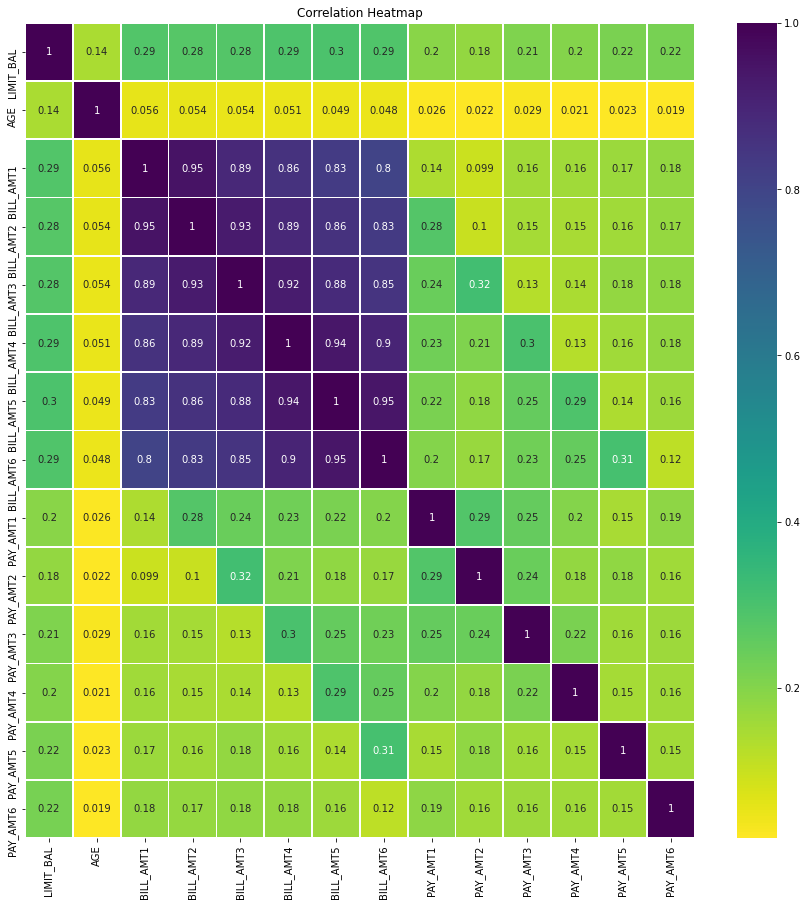

In [52]:
plt.figure(figsize=(15, 15))
plt.title('Correlation Heatmap')
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='viridis_r', linecolor='white', linewidths=0.8)
plt.show()

There is a high correlation between BILL_AMT1 and BILL_AMT2, 3, 4...

Taking Mean of all BILL_AMT

In [53]:
df['BILL_AMT_MEAN'] = (df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + \
df['BILL_AMT5'] + df['BILL_AMT6']) / 6

In [54]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month', 'AGE_GROUP', 'BILL_AMT_MEAN'],
      dtype='object')

In [55]:
df_copy = df.copy()

In [56]:
selected_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month', 'AGE_GROUP', 'BILL_AMT_MEAN']

In [57]:
df_copy = df_copy[selected_cols]
df_copy.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month',
       'AGE_GROUP', 'BILL_AMT_MEAN'],
      dtype='object')

In [58]:
numerical_cols = [col for col in df_copy.columns.tolist() if col in numerical_cols]
numerical_cols.append('BILL_AMT_MEAN')
numerical_cols

['LIMIT_BAL',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'BILL_AMT_MEAN']

In [59]:
categorical_cols.append('AGE_GROUP')
categorical_cols

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'AGE_GROUP']

## Feature Engineering

In [60]:
def plot_distribution(df, cols):
    for col in cols:
        plt.figure(figsize=(8,8))
        plt.title('%s distribution' %col)
        sns.distplot(df[col], bins=30)
        plt.show()

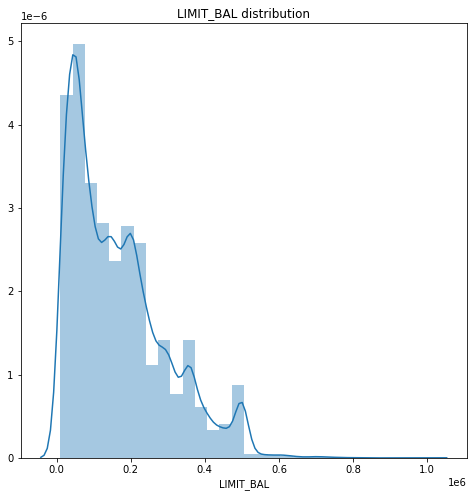

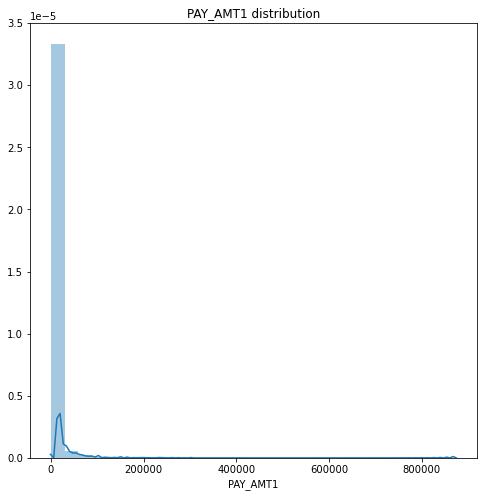

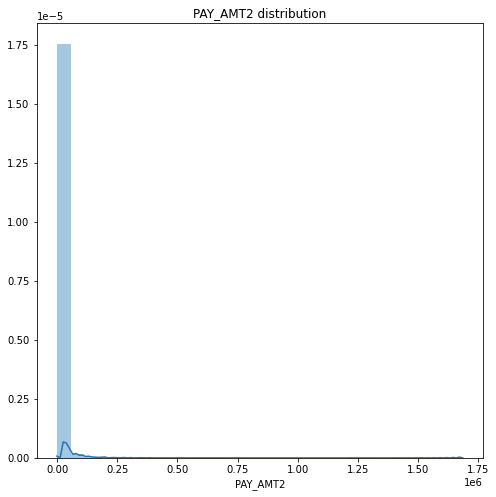

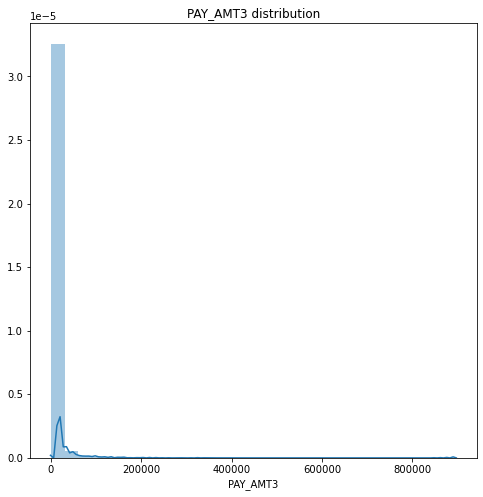

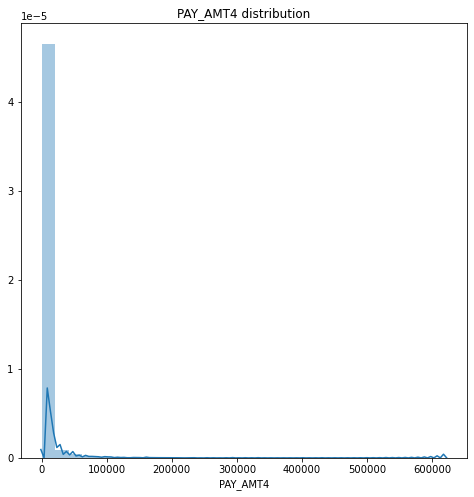

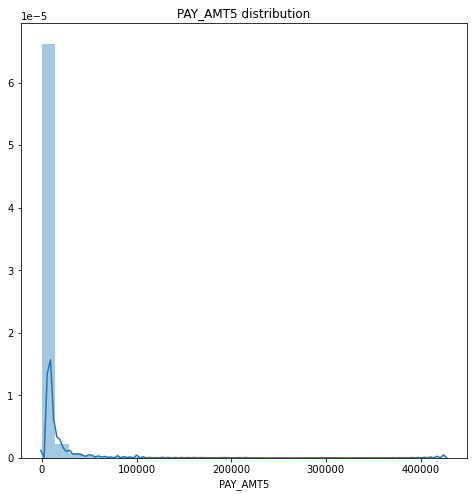

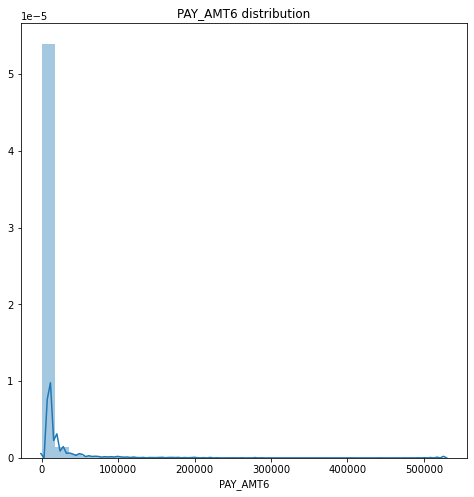

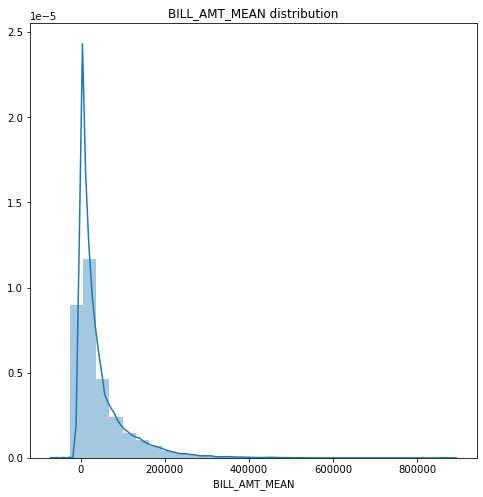

In [61]:
plot_distribution(df_copy, numerical_cols)

Distribution plot shows skewness in data

In [62]:
def plot_scatter(df, cols, cols2, target_col):
    for col in cols:
        plt.figure(figsize=(8,8))
        plt.title('%s scatterplot' %col)
        sns.scatterplot(x=col, y=cols2, data=df, hue=target_col)
        plt.show()

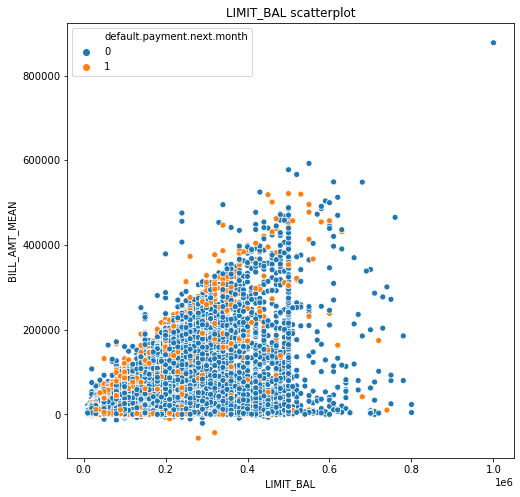

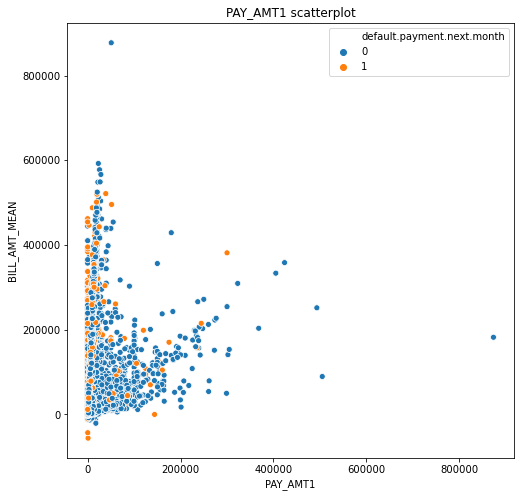

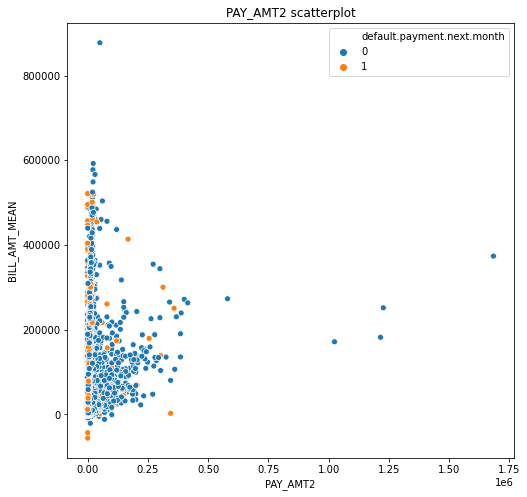

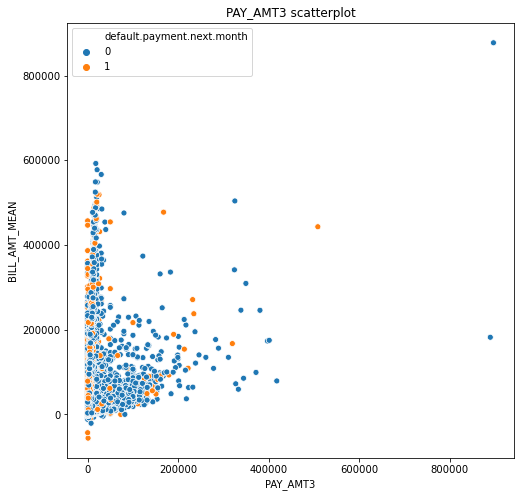

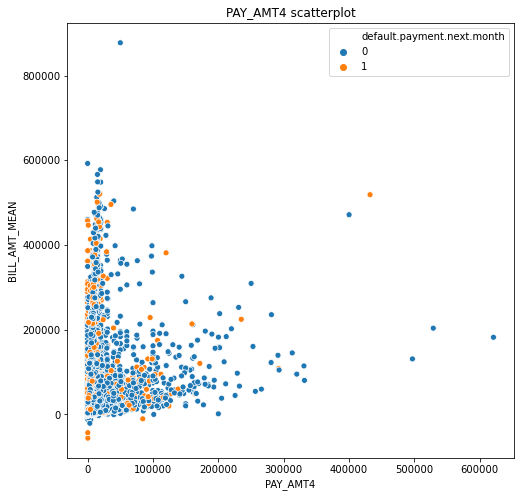

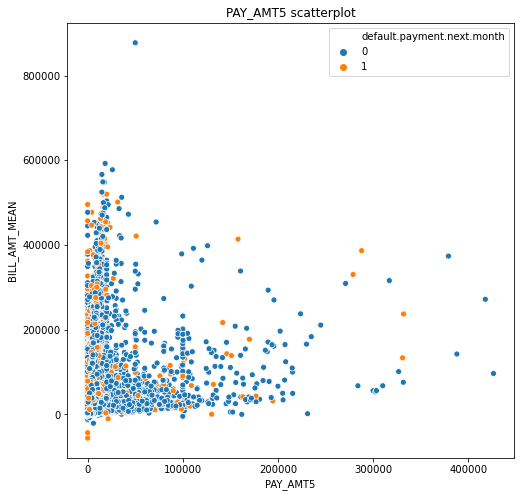

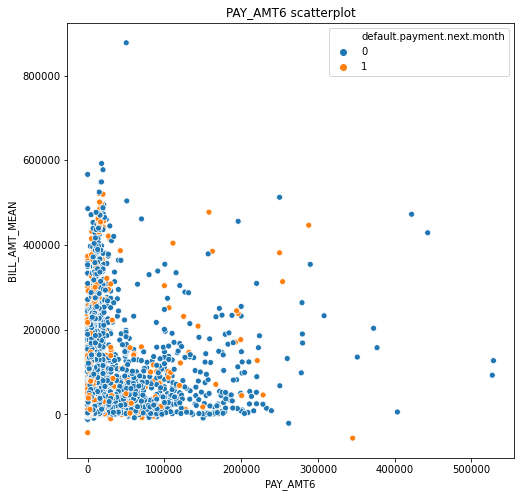

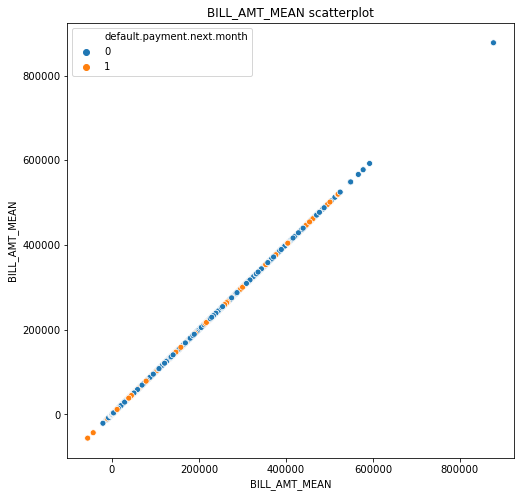

In [63]:
plot_scatter(df_copy, numerical_cols, 'BILL_AMT_MEAN', target_col)

Scatterplot show presence of skewness. 

In [64]:
def plot_boxplot(df, cols):
    for col in cols:
        plt.figure(figsize=(8,8))
        plt.title('%s boxplot' %col)
        sns.boxplot(y=df[col])
        plt.show()

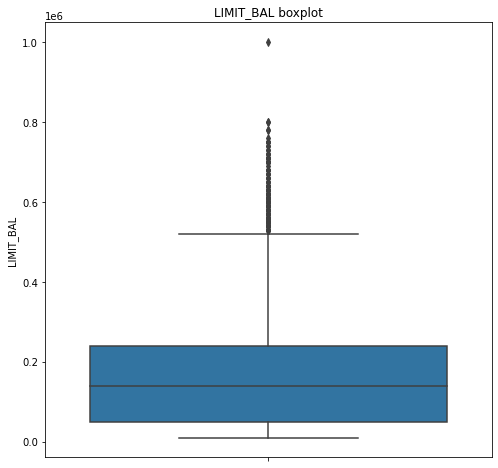

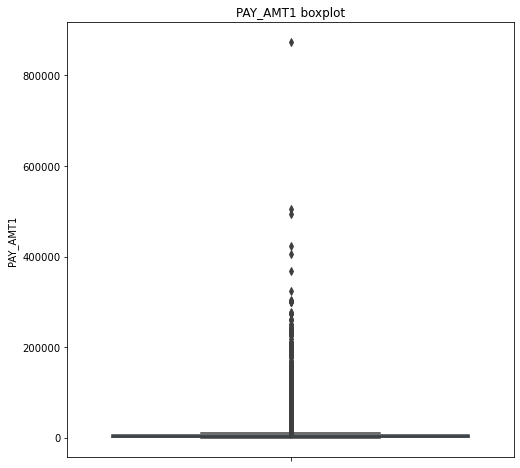

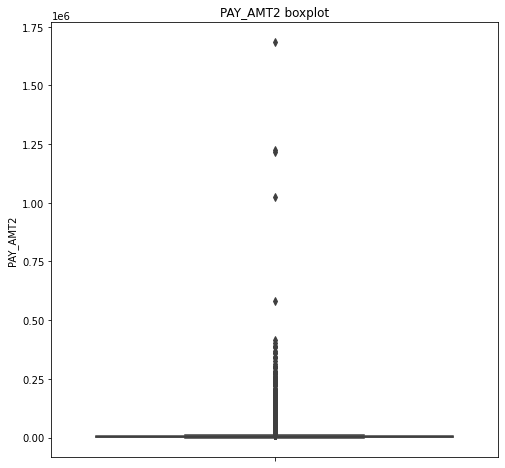

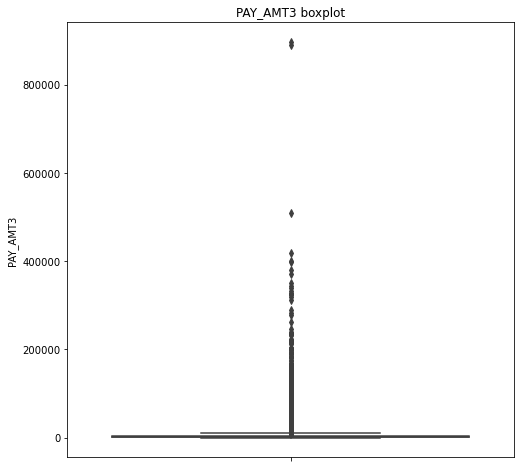

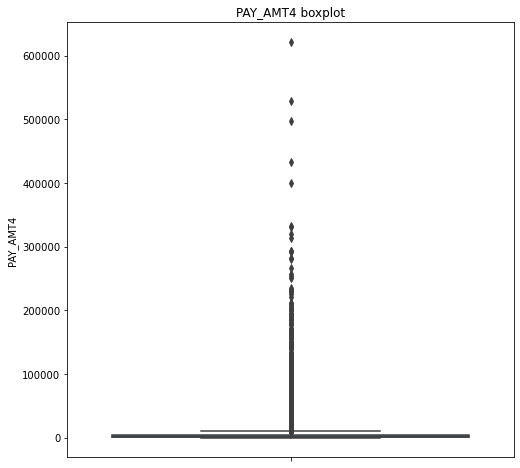

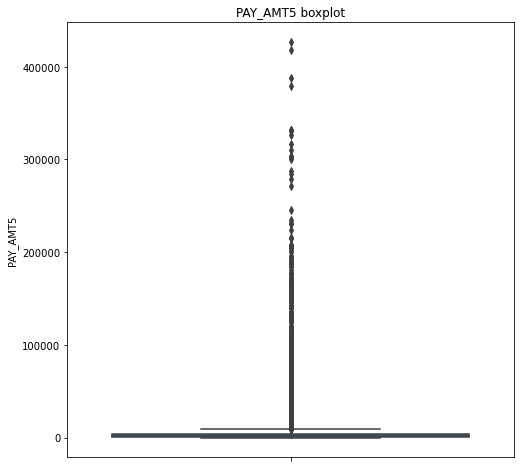

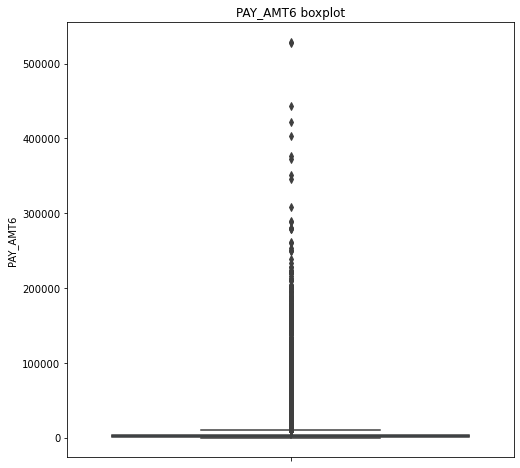

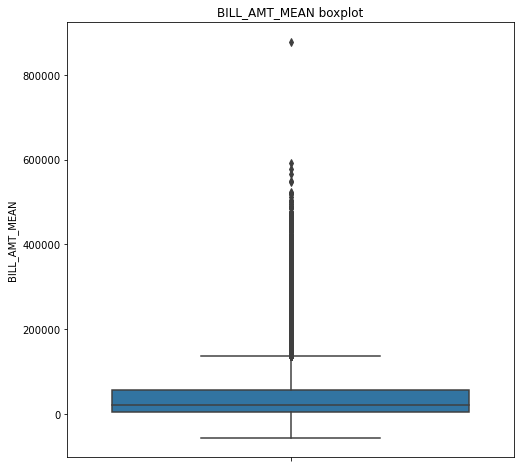

In [65]:
plot_boxplot(df_copy, numerical_cols)

In [66]:
df_copy[numerical_cols].describe()

,LIMIT_BAL,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT_MEAN
count,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,44976.945200
std,129747.661567,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,63260.721860
min,10000.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,-56043.166667
25%,50000.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,4781.333333
50%,140000.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,21051.833333
75%,240000.000000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,57104.416667
max,1000000.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,877313.833333


Applying boxcox/yeojohnson transformation to numerical columns

In [67]:
for col in numerical_cols:
    if df_copy[col].min() <= 0:
        # applying yeojohnson tranformation due to presence of zero or negative values
        df_copy[col+'_transformed'] = stats.yeojohnson(df_copy[col])[0].tolist()
    else:
        df_copy[col+'_transformed'] = stats.boxcox(df_copy[col])[0].tolist()

In [68]:
df_copy.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,BILL_AMT_MEAN,LIMIT_BAL_transformed,PAY_AMT1_transformed,PAY_AMT2_transformed,PAY_AMT3_transformed,PAY_AMT4_transformed,PAY_AMT5_transformed,PAY_AMT6_transformed,BILL_AMT_MEAN_transformed
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200,44976.945200,83.405098,18.570387,17.169297,14.810331,13.194731,13.069190,11.983179,7266.322587
std,129747.661567,0.489129,0.790349,0.521970,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062,63260.721860,20.609974,10.768919,10.067875,9.086266,8.361448,8.394088,7.905514,8945.827549
min,10000.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,-56043.166667,40.146711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-330514.492615
25%,50000.000000,1.000000,1.000000,1.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000,4781.333333,63.745208,15.939223,14.397391,10.956261,9.670086,9.230217,7.105562,1293.760428
50%,140000.000000,2.000000,2.000000,2.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000,21051.833333,85.130960,19.507425,18.182131,16.332231,14.648593,14.597187,13.683933,4382.712018
75%,240000.000000,2.000000,2.000000,2.000000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000,57104.416667,98.906427,24.481308,22.888121,20.377246,18.422936,18.366839,17.013271,9962.708605
max,1000000.000000,2.000000,6.000000,3.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000,877313.833333,146.591179,84.016840,85.922262,63.677469,51.898703,47.951114,43.874837,94327.771839


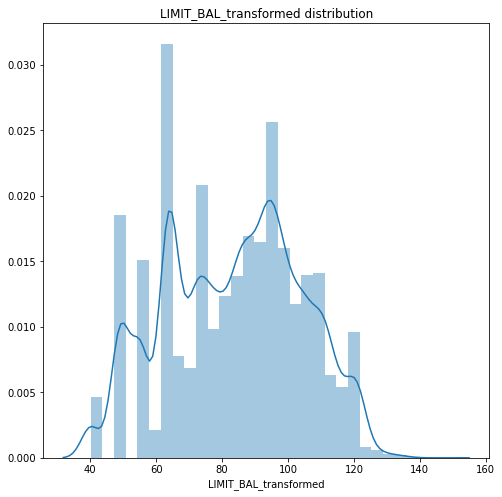

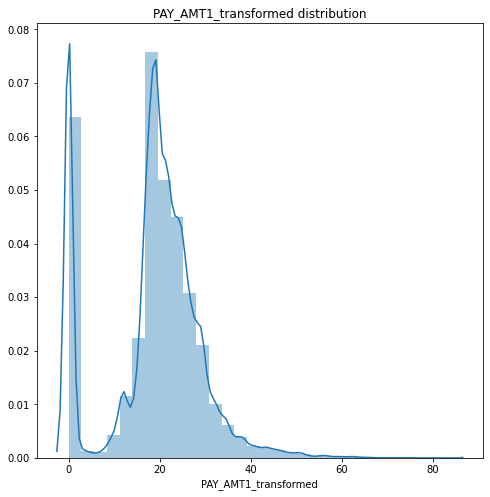

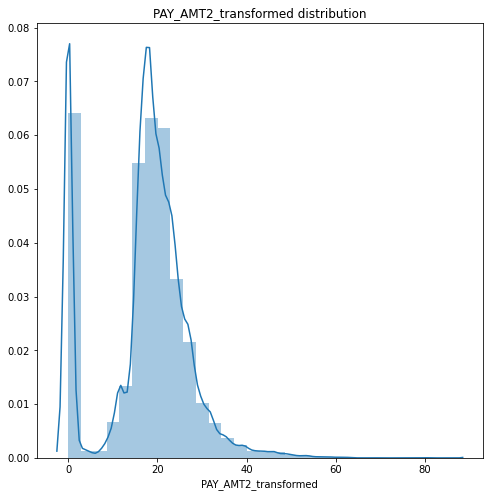

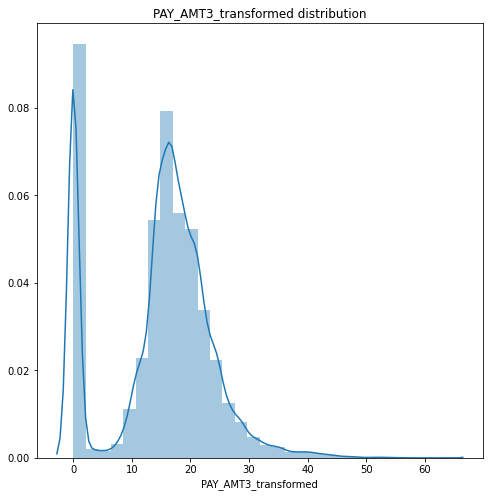

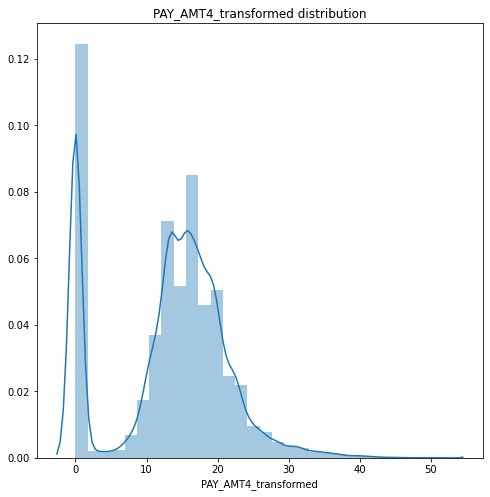

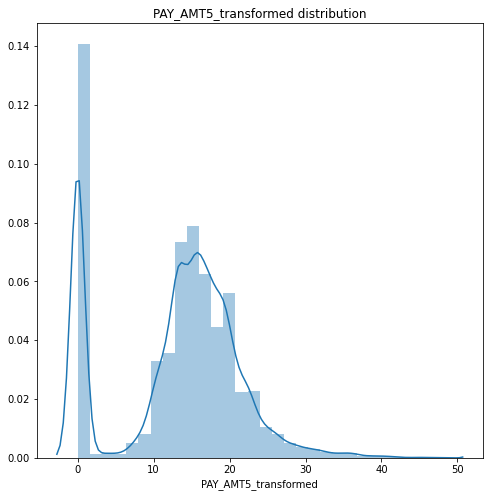

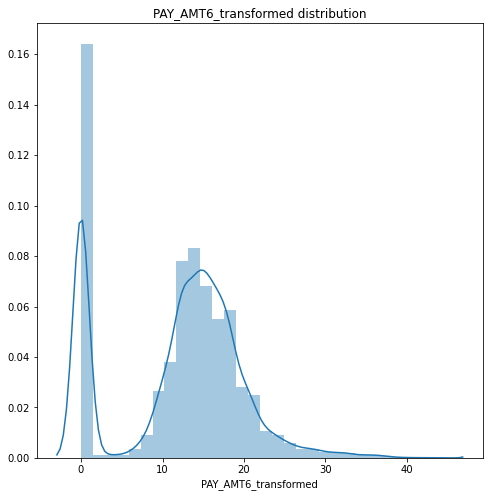

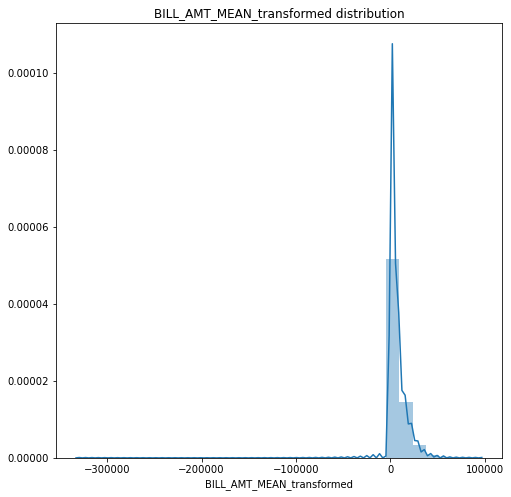

In [69]:
transformed_cols = [col+'_transformed' for col in numerical_cols]
plot_distribution(df_copy, transformed_cols)

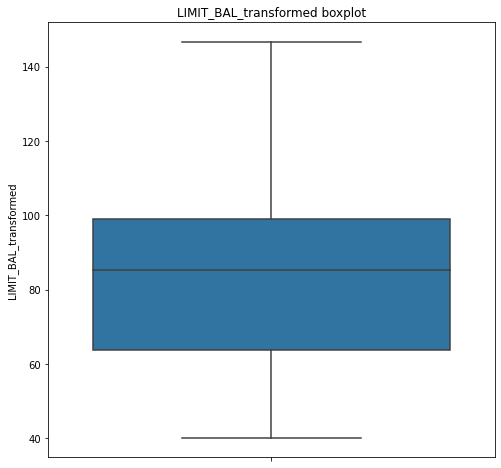

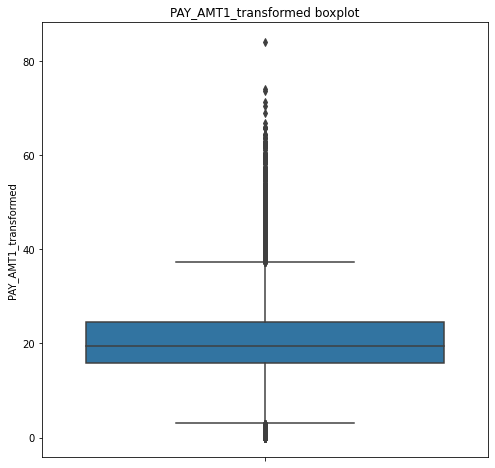

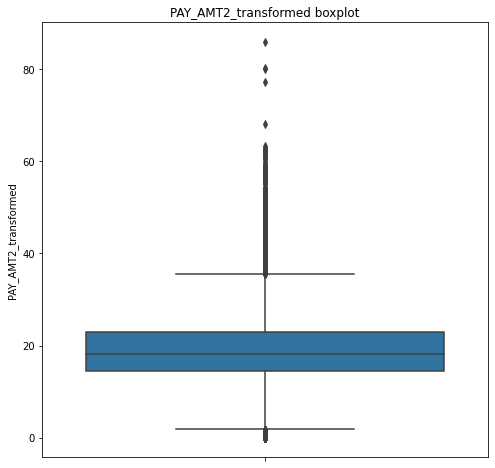

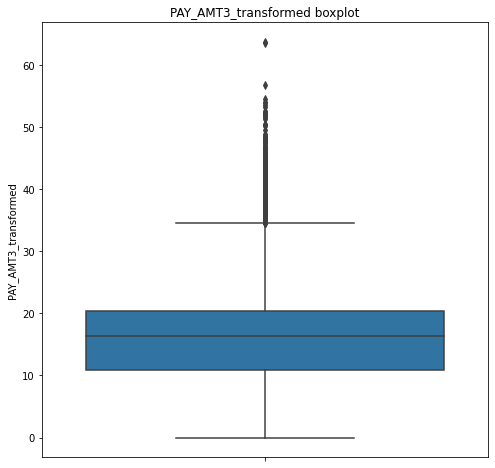

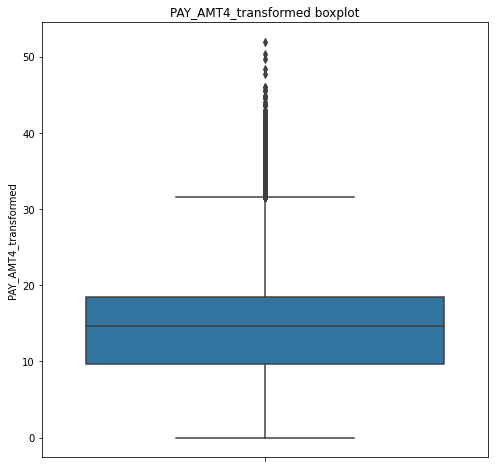

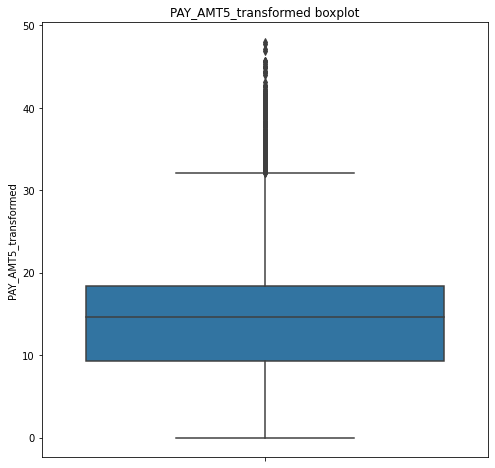

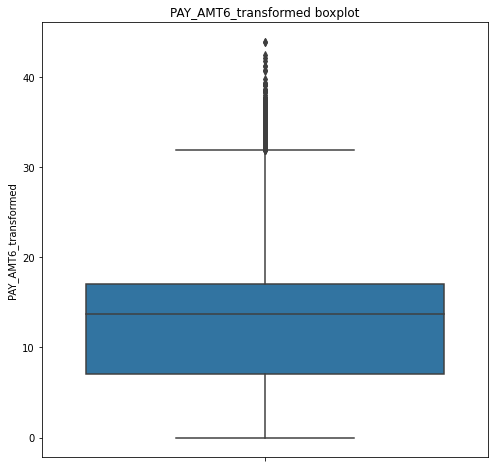

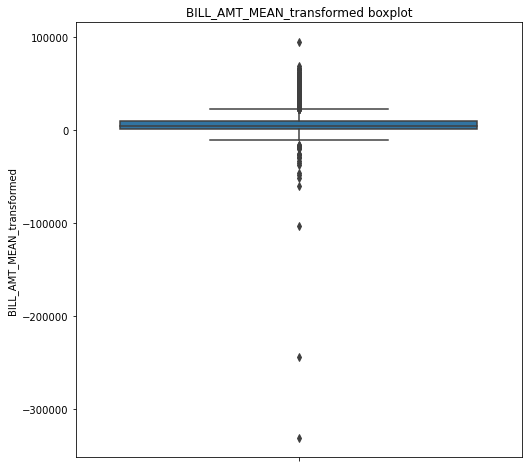

In [70]:
plot_boxplot(df_copy, transformed_cols)

In [71]:
df_copy.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month',
       'AGE_GROUP', 'BILL_AMT_MEAN', 'LIMIT_BAL_transformed',
       'PAY_AMT1_transformed', 'PAY_AMT2_transformed', 'PAY_AMT3_transformed',
       'PAY_AMT4_transformed', 'PAY_AMT5_transformed', 'PAY_AMT6_transformed',
       'BILL_AMT_MEAN_transformed'],
      dtype='object')

In [72]:
final_selected_columns = ['LIMIT_BAL_transformed', 'PAY_AMT1_transformed', 'PAY_AMT2_transformed', 
        'PAY_AMT3_transformed', 'PAY_AMT4_transformed', 'PAY_AMT5_transformed', 
        'PAY_AMT6_transformed', 'BILL_AMT_MEAN_transformed', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'AGE_GROUP', 'default.payment.next.month']

final_df = df_copy[final_selected_columns]

In [73]:
final_df.head()

,LIMIT_BAL_transformed,PAY_AMT1_transformed,PAY_AMT2_transformed,PAY_AMT3_transformed,PAY_AMT4_transformed,PAY_AMT5_transformed,PAY_AMT6_transformed,BILL_AMT_MEAN_transformed,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,AGE_GROUP,default.payment.next.month
0,49.082143,0.000000,13.666855,0.000000,0.000000,0.000000,0.000000,437.991210,2,2,1,Normal Delay,Normal Delay,No Delay,No Delay,No Delay,No Delay,1,1
1,81.542735,0.000000,15.128001,14.082133,13.270653,0.000000,14.607927,843.963456,2,2,2,No Delay,Normal Delay,No Delay,No Delay,No Delay,Normal Delay,1,1
2,75.229203,17.875960,16.849974,14.082133,13.270653,13.227050,17.844918,3665.369315,2,2,2,No Delay,No Delay,No Delay,No Delay,No Delay,No Delay,2,0
3,63.745208,19.254791,18.205463,14.753799,13.585931,13.446003,12.450552,7211.217281,2,2,1,No Delay,No Delay,No Delay,No Delay,No Delay,No Delay,2,0
4,63.745208,19.254791,36.786573,24.501949,22.036026,12.049828,11.344150,3891.972556,1,2,1,No Delay,No Delay,No Delay,No Delay,No Delay,No Delay,3,0


#### Train/Test Split

In [74]:
# 70-30 Split for train and test
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(target_col, axis=1),\
                                                    final_df[target_col], test_size=0.3, random_state=2021)

In [75]:
final_numerical_cols = ['LIMIT_BAL_transformed', 'PAY_AMT1_transformed', 'PAY_AMT2_transformed', 
        'PAY_AMT3_transformed', 'PAY_AMT4_transformed', 'PAY_AMT5_transformed', 
        'PAY_AMT6_transformed', 'BILL_AMT_MEAN_transformed']

nominal_cols = ['SEX', 'MARRIAGE', 'AGE_GROUP']
ordinal_cols = ['EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

#### Scaling Numerical Features

In [76]:
num_scaler = MinMaxScaler()
num_train_df = pd.DataFrame(num_scaler.fit_transform(X_train[final_numerical_cols]),\
                      columns=final_numerical_cols)
num_test_df = pd.DataFrame(num_scaler.transform(X_test[final_numerical_cols]),\
                      columns=final_numerical_cols)

#### Encoding Categorical Features

In [77]:
cat_ord_train_df = pd.DataFrame()
enc_class_dict = {}
for col in ordinal_cols:
    l_enc = LabelEncoder()
    encoded_df = pd.DataFrame(l_enc.fit_transform(X_train[col]), columns=[col])
    cat_ord_train_df = pd.concat([cat_ord_train_df, encoded_df], axis=1)
    enc_class_dict[col] = l_enc.classes_

cat_ord_test_df = pd.DataFrame()
for col in ordinal_cols:
    l_enc = LabelEncoder()
    l_enc.classes_ = enc_class_dict[col]
    encoded_df = pd.DataFrame(l_enc.transform(X_test[col]), columns=[col])
    cat_ord_test_df = pd.concat([cat_ord_test_df, encoded_df], axis=1)

In [78]:
ohe = OneHotEncoder(drop='first')

In [79]:
cat_nom_train_df = pd.DataFrame(ohe.fit_transform(X_train[nominal_cols]).toarray(),\
             columns=ohe.get_feature_names(input_features=nominal_cols))

cat_nom_test_df = pd.DataFrame(ohe.transform(X_test[nominal_cols]).toarray(),\
             columns=ohe.get_feature_names(input_features=nominal_cols))

In [80]:
X_train = pd.concat([num_train_df, cat_ord_train_df, cat_nom_train_df], axis=1)
X_test = pd.concat([num_test_df, cat_ord_test_df, cat_nom_test_df], axis=1)

## Training Model

#### Starting with simple Logistic Regression Model

In [81]:
lr = LogisticRegression()

In [82]:
lr.fit(X_train, y_train)

LogisticRegression()

In [83]:
training_score = lr.score(X_train, y_train)
print('Training Accuracy: %.2f' %training_score)

Training Accuracy: 0.80


In [91]:
class ClassificationModelHelper():
    
    def __init__(self, experiment_name, model_dict = None):
        
        self._experiment_name = experiment_name
        
        if not model_dict == None:
            self._model_dict = model_dict
            return None
        
        rfc = RandomForestClassifier()
        gbc = GradientBoostingClassifier()
        xgbc = XGBClassifier()
        
        rfc_params = {'n_estimators':[500, 1000], 'max_depth':[3, 5], 'min_samples_split':[2,4], 'bootstrap':[True]}      
        gbc_params = {'learning_rate':[0.1, 0.01, 0.001], 'n_estimators':[500, 1000], 'max_depth':[3, 5], 'min_samples_split':[2,4]}
        xgbc_params = {'learning_rate':[0.1, 0.01, 0.001], 'n_estimators':[500, 1000], 'max_depth':[3, 5]}
        
        self._model_dict = {rfc: [rfc_params, 'RandomForest Classifier'], gbc: [gbc_params, 'GradientBoosting Classifier'], xgbc: [xgbc_params, 'XGBoost Classifier']}
        
        return None
    
    def show_model_summary(self, model_name, y_true, y_pred, y_pred_prob):
        
        print('\n\n===========================================\n\n')
        
        print('%s model summary' %model_name)
        print('Classification Report: ')
        print(classification_report(y_true, y_pred))
        print('Confusion Matrix: ')
        print(confusion_matrix(y_true, y_pred))
        print('Logloss: ', log_loss(y_true, y_pred_prob[:, 1]))
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)        
        auc_score = roc_auc_score(y_true, y_pred_prob[:, 1])
        print('auc: ', auc_score)
        
        print('\n\n===========================================\n\n')
        
        model_metrics = {'accuracy': accuracy, 'precision': precision, 'f1_score': f1, 'log_loss': log_loss(y_true, y_pred_prob[:, 1]), 'auc': auc_score}
        return model_metrics
        
        
    def _log_model(self, model_experiment_summaries):
        mlflow.set_experiment(self._experiment_name)
        for summary in model_experiment_summaries:
            run_name = summary['run_name']
            run_params = summary['run_params']
            run_metrics = summary['run_metrics']
            with mlflow.start_run(run_name=run_name):
                mlflow.log_params(run_params)
                mlflow.log_metrics(run_metrics)

    def _run(self, model, X_train, X_test, y_train, y_test, cross_validation, verbose):
        model_obj = model
        model_params = self._model_dict[model][0]
        model_name = self._model_dict[model][1]
            
        grid_model = GridSearchCV(model_obj, param_grid=model_params, cv=cross_validation, verbose=verbose, n_jobs=2)
        print('Training %s \n' %model_name)
        grid_model.fit(X_train, y_train)
        print('Training finished.\n\n')
            
        print('%s Best Params: ' %model_name)
        model_params = grid_model.best_params_
        print(model_params)
            
        y_pred = grid_model.predict(X_test)
        y_pred_prob = grid_model.predict_proba(X_test)
        model_metrics = self.show_model_summary(model_name, y_test, y_pred, y_pred_prob)
             
        model_experiment_summary = {'run_name': model_name, 'run_params': model_params, 'run_metrics': model_metrics}
        return model_experiment_summary
                
    
    def train_model(self, X_train, X_test, y_train, y_test, n_folds=5, verbose=1):
        start_time = perf_counter()
        print('Starting experiment: %s' %self._experiment_name)
        print('\n')
        model_experiment_summaries = []
        for model in self._model_dict.keys():
            
            model_experiment_summary = self._run(model, X_train, X_test, y_train, y_test, n_folds, verbose)
            model_experiment_summaries.append(model_experiment_summary)
            print('\n\n')
            
        self._log_model(model_experiment_summaries)
        print('\n Experiment is logged to mlflow.')
        end_time = perf_counter()
        minutes_taken = round((float(end_time-start_time)/60.0), 2)
        print('\nTotal time taken = %.2f minutes' %minutes_taken)  

In [92]:
model_trainer = ClassificationModelHelper(experiment_name='CC_Logistic_Regression')

In [93]:
y_pred_lr = lr.predict(X_test)
y_pred_prob_lr = lr.predict_proba(X_test) 

In [94]:
model_trainer.show_model_summary('Logistic Regression', y_test, y_pred_lr, y_pred_prob_lr)





Logistic Regression model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7020
           1       0.61      0.28      0.39      1980

    accuracy                           0.80      9000
   macro avg       0.72      0.62      0.63      9000
weighted avg       0.78      0.80      0.77      9000

Confusion Matrix: 
[[6666  354]
 [1421  559]]
Logloss:  0.4489227842158108
auc:  0.7574627687127687






{'accuracy': 0.8027777777777778,
 'precision': 0.6122672508214677,
 'f1_score': 0.3864500518492914,
 'log_loss': 0.4489227842158108,
 'auc': 0.7574627687127687}

In [95]:
over_sampler = SMOTE()

In [96]:
X_train_over_sampled, y_train_over_sampled = over_sampler.fit_sample(X_train, y_train)

In [98]:
lr_on_oversampled = LogisticRegression()

In [99]:
lr_on_oversampled.fit(X_train_over_sampled, y_train_over_sampled)

LogisticRegression()

In [101]:
print('Training Accuracy: %.2f' %lr_on_oversampled.score(X_train_over_sampled, y_train_over_sampled))

Training Accuracy: 0.69


In [102]:
y_pred_over_sampled = lr_on_oversampled.predict(X_test)
y_pred_prob_over_sampled = lr_on_oversampled.predict_proba(X_test)

In [103]:
model_trainer.show_model_summary('Logistic Regression on Oversampled data', y_test, y_pred_over_sampled,\
                                 y_pred_prob_over_sampled)





Logistic Regression on Oversampled data model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      7020
           1       0.44      0.63      0.52      1980

    accuracy                           0.74      9000
   macro avg       0.66      0.70      0.67      9000
weighted avg       0.78      0.74      0.76      9000

Confusion Matrix: 
[[5420 1600]
 [ 733 1247]]
Logloss:  0.5853657655267595
auc:  0.7580881823937379






{'accuracy': 0.7407777777777778,
 'precision': 0.43800491745697223,
 'f1_score': 0.5166770250673296,
 'log_loss': 0.5853657655267595,
 'auc': 0.7580881823937379}

 #### Feature Selection using Recursive Feature Elimination

In [109]:
rfe = RFECV(estimator=LogisticRegression(), min_features_to_select=5, cv=5,\
            scoring=make_scorer(f1_score), n_jobs=2, verbose=1)

In [110]:
rfe.fit(X_train_over_sampled, y_train_over_sampled)

Fitting estimator with 22 features.
Fitting estimator with 21 features.


RFECV(cv=5, estimator=LogisticRegression(), min_features_to_select=5, n_jobs=2,
      scoring=make_scorer(f1_score), verbose=1)

In [120]:
selected_features_dict = dict(zip(X_train_over_sampled.columns.tolist(), rfe.get_support()))

selected_features = [col for col in selected_features_dict.keys() if selected_features_dict[col] == True]
selected_features

['LIMIT_BAL_transformed',
 'PAY_AMT1_transformed',
 'PAY_AMT2_transformed',
 'PAY_AMT3_transformed',
 'PAY_AMT4_transformed',
 'PAY_AMT6_transformed',
 'BILL_AMT_MEAN_transformed',
 'EDUCATION',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'SEX_2',
 'MARRIAGE_1',
 'MARRIAGE_2',
 'MARRIAGE_3',
 'AGE_GROUP_3',
 'AGE_GROUP_4']

In [122]:
X_train_new = X_train_over_sampled[selected_features]
X_test_new = X_test[selected_features]

In [123]:
trained_rfe_model = rfe.estimator_

In [125]:
y_pred_new = trained_rfe_model.predict(X_test_new)
y_pred_prob_new = trained_rfe_model.predict_proba(X_test_new)

In [126]:
model_trainer.show_model_summary('Logistic Regression on selected features', y_test, y_pred_new,\
                                 y_pred_prob_new)





Logistic Regression on selected features model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      7020
           1       0.44      0.63      0.52      1980

    accuracy                           0.74      9000
   macro avg       0.66      0.70      0.67      9000
weighted avg       0.78      0.74      0.76      9000

Confusion Matrix: 
[[5420 1600]
 [ 728 1252]]
Logloss:  0.5859751505093547
auc:  0.7578084261417595






{'accuracy': 0.7413333333333333,
 'precision': 0.43899018232819076,
 'f1_score': 0.5182119205298014,
 'log_loss': 0.5859751505093547,
 'auc': 0.7578084261417595}

### Training Ensemble models

In [132]:
model_trainer = ClassificationModelHelper(experiment_name='Credit Payment Default')
model_trainer.train_model(X_train_new, X_test_new, y_train_over_sampled, y_test)

Starting experiment: Credit Payment Default


Training RandomForest Classifier 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:  3.8min finished


Training finished.


RandomForest Classifier Best Params: 
{'bootstrap': True, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}




RandomForest Classifier model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7020
           1       0.49      0.60      0.54      1980

    accuracy                           0.77      9000
   macro avg       0.68      0.71      0.69      9000
weighted avg       0.79      0.77      0.78      9000

Confusion Matrix: 
[[5756 1264]
 [ 789 1191]]
Logloss:  0.5730615207570762
auc:  0.7665054030331809







Training GradientBoosting Classifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 21.6min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 64.0min finished


Training finished.


GradientBoosting Classifier Best Params: 
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}




GradientBoosting Classifier model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      7020
           1       0.55      0.41      0.47      1980

    accuracy                           0.80      9000
   macro avg       0.70      0.66      0.67      9000
weighted avg       0.78      0.80      0.79      9000

Confusion Matrix: 
[[6358  662]
 [1167  813]]
Logloss:  0.47930140130809995
auc:  0.7416730697286253







Training XGBoost Classifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  8.1min finished


Training finished.


XGBoost Classifier Best Params: 
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}




XGBoost Classifier model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      7020
           1       0.57      0.42      0.48      1980

    accuracy                           0.80      9000
   macro avg       0.71      0.67      0.68      9000
weighted avg       0.79      0.80      0.79      9000

Confusion Matrix: 
[[6395  625]
 [1148  832]]
Logloss:  0.4663461991548247
auc:  0.7482588347866125







INFO: 'Credit Payment Default' does not exist. Creating a new experiment

 Experiment is logged to mlflow.

Total time taken = 78.68 minutes
